<a href="https://colab.research.google.com/github/tfredrick112/Hands-On-ML/blob/master/MNIST_Chapter_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Digits Classification - Chapter 3 Hands-On ML

In [1]:
!nvidia-smi

Tue Jan 28 17:16:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import numpy as np
import pandas as pd

# to keep the output consistent across several runs
np.random.seed(42)

# to print nicely labelled plots
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
print(mnist.keys())

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])


The image vectors can be found in mnist['data'] and their labels will be in mnist['target']. 

The first 60,000 images are training data and the remaining 10,000 are test data.

In [4]:
X = mnist['data']
y = mnist['target']
y = y.astype(np.uint8)

print("Shape of the data matrix: ", X.shape)
print("Shape of the labels matrix: ", y.shape)

X_train = X[:60000]
y_train = y[:60000]
X_test = X[60000:]
y_test = y[60000:]

Shape of the data matrix:  (70000, 784)
Shape of the labels matrix:  (70000,)


Here are some example images from the training set.

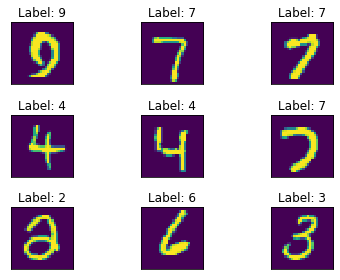

In [5]:
import random
random.seed(45)
indices = random.sample(range(60000), 9)
for i in range(len(indices)):
  plt.subplot(3, 3, i + 1)
  plt.imshow(X_train[indices[i]].reshape(28, 28))
  plt.title("Label: {}".format(y_train[indices[i]]))
  plt.xticks([])
  plt.yticks([])
plt.tight_layout()
plt.show()

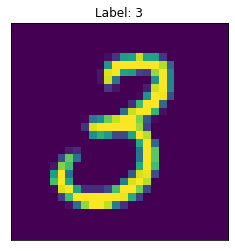

In [6]:
ind = indices[-1]
plt.imshow(X_train[ind].reshape(28, 28))
plt.title("Label: {}".format(y_train[ind]))
plt.xticks([])
plt.yticks([])
plt.show()

chosen_digit = y_train[ind]

### Binary Classifier

I will first use the Stochastic Gradient Descent classifier to build a binary classifier that will decide whether a given image is a "3" or not. I will use cross validation to check the accuracy on the cross validation sets.

In [7]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score

sgd_clf = SGDClassifier(random_state=42)

# special label sets (True or False) for the binary classifier
y_train_3 = (y_train == chosen_digit)
y_test_3 = (y_test == chosen_digit)

sgd_clf.fit(X_train, y_train_3)
sgd_scores = cross_val_score(sgd_clf, X_train, y_train_3, cv=3, scoring='accuracy')
print("Cross validation scores = {}".format(sgd_scores))

Cross validation scores = [0.9496  0.9624  0.96275]


The cv scores are all very high, but this could also be because of the bias in the dataset. Since each number makes up for around 10% of the total images, if our classifier just predicted "not 3" for all the images, we would easily get around 90% (actually even greater) accuracy. It is easy to demonstrate this.

In [8]:
from sklearn.base import BaseEstimator

class Not3Classifier(BaseEstimator):
  def fit(self, X, y=None):
    pass
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

not3_clf = Not3Classifier()
not3_clf.fit(X_train, y_train_3)

not3_scores = cross_val_score(not3_clf, X_train, y_train_3, cv=3, scoring='accuracy')
print("Cross validation scores = {}".format(not3_scores))

Cross validation scores = [0.8962  0.89975 0.8975 ]


As expected, the scores are close to 90%. This is bad, because our classifier is a very naive one, it just predicts "not 3" for every example.

### Confusion Matrix



[[53477   392]
 [ 2113  4018]]


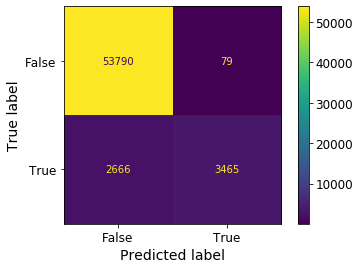

In [9]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

predictions = cross_val_predict(sgd_clf, X_train, y_train_3, cv=3)
print(confusion_matrix(y_train_3, predictions))
plot_confusion_matrix(sgd_clf, X_train, y_train_3, values_format='g')
# values_format = 'g' ensures that numbers are nor printed in scientific notation

The above matrix can be interpreted as:
* Top left square: True Negatives, images for which the actual class is "not 3" and the predicted class is also "not 3".
* Bottom left square: False Negative, images where the actual class is "3", but we predicted a "not 3".
* Top right: False Positives, image is actually a "not 3", but we predicted "3".
* Bottom right: True Positive, image is "3", and we predicted "3".

In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score
print("Metrics calculated using the inbuilt functions:")
print("Precision : ", precision_score(y_train_3, predictions))
print("Recall : ", recall_score(y_train_3, predictions))
print("F1 score : ", f1_score(y_train_3, predictions))

Metrics calculated using the inbuilt functions:
Precision :  0.9111111111111111
Recall :  0.655358016636764
F1 score :  0.7623565126648326


The precision tells us that when the model predicts that an image is a 5, it does so with 91.11% accuracy, and the recall tells us that it is identifying only 65.35% of all the 5s.

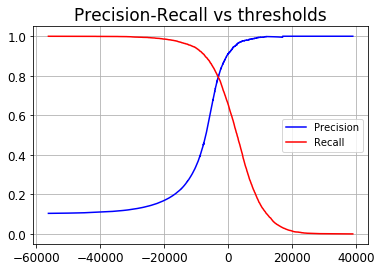

In [11]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_3, cv=3, method='decision_function')
precisions, recalls, thresholds = precision_recall_curve(y_train_3, y_scores)

def plot_precision_recall_curve(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], 'b', label='Precision')
  plt.plot(thresholds, recalls[:-1], 'r', label='Recall')
  plt.title("Precision-Recall vs thresholds", size=17)
  plt.grid()
  plt.legend()
  plt.show()

plot_precision_recall_curve(precisions, recalls, thresholds)

### Precision vs Recall curve

We must use this curve when the **positive class is rare**, or in those cases where we **worry more about the false positives** than the false negatives. The better the classifier, the value of "area under the curve" will be closer to 1.

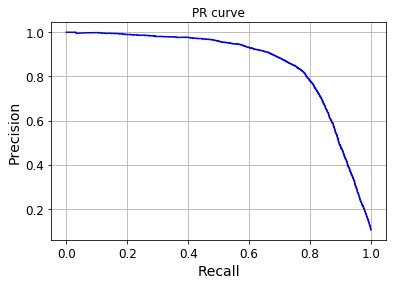

In [0]:
def plot_PR_curve(precisions, recalls):
  plt.plot(recalls, precisions, 'b', label='PR curve')
  plt.title("PR curve")
  plt.ylabel("Precision", size=14)
  plt.xlabel("Recall", size=14)
  plt.grid()
  plt.show()

plot_PR_curve(precisions, recalls)

There is a trade-off between precision and recall. We should choose a point just before the sharp drop happens for good performance.

### ROC curve
It stands for Region Operating Characteristics curve. A better curve will have area under the curve closer to 1. The ROC curve is plotted with the true positive rate (tpr) on the y axis and false positive rate(fpr) on x axis.

The true positive rate is also called recall or sensitivity. The FPR is the ratio of negative instances that are incorrectly classified as positive.

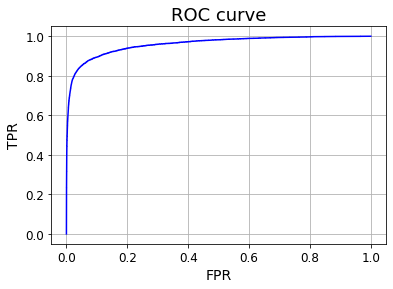

In [12]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_3, y_scores)
def plot_ROC_curve(tpr, fpr):
  plt.plot(fpr, tpr, 'b', label='PR curve')
  plt.title("ROC curve", size=18)
  plt.ylabel("TPR", size=14)
  plt.xlabel("FPR", size=14)
  plt.grid()
  plt.show()

plot_ROC_curve(tpr, fpr)

In [13]:
from sklearn.metrics import roc_auc_score
print("Area under the ROC curve = ",roc_auc_score(y_train_3, y_scores))

Area under the ROC curve =  0.9599243001892759


I want to compare the performance of SGDClassifier with a RandomForestClassifier.

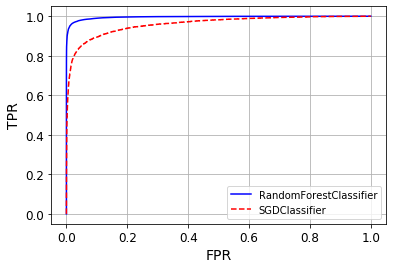

In [14]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(X_train, y_train_3)
forest_scores = cross_val_predict(forest_clf, X_train, y_train_3, cv=3, method='predict_proba')
forest_scores_usable = forest_scores[:, 1]

# To compare the ROC curves.
fpr2, tpr2, threshold2 = roc_curve(y_train_3, forest_scores_usable)

plt.plot(fpr2, tpr2, 'b-', label='RandomForestClassifier')
plt.plot(fpr, tpr, 'r--', label='SGDClassifier')
plt.grid()
plt.xlabel("FPR", size=14)
plt.ylabel("TPR", size=14)
plt.legend()
plt.show()

### Multi-class classification

When we try to use a binary classifier for a multi-class classification problem, scikit-learn detects this and automatically uses the OvA (one-vs-all) approach excpet for SVM, where OvO is preferred, as SVM scales very poorly with the size of the training set.

In [0]:
sgd_clf.fit(X_train, y_train)
# indices is an array of 9 randomly chosen indices.
sgd_clf_predictions = sgd_clf.predict(X_train[indices])

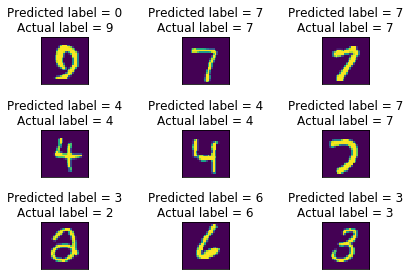

In [16]:
for i in range(len(indices)):
  plt.subplot(3, 3, i+1)
  plt.imshow(X_train[indices[i]].reshape(28, 28))
  plt.xticks([])
  plt.yticks([])
  plt.title("Predicted label = {}\nActual label = {}".format(sgd_clf_predictions[i], y_train[indices[i]]))

plt.tight_layout()
plt.show()

The multi-class classifier assigns a score for each of the 10 classes. It will assign the image to that class which had the highest score.

In [0]:
# to find the scores for each class for some random image
sgd_clf_scores = sgd_clf.decision_function([X_train[indices[1]]])
print("Scores for the various classes: ", sgd_clf_scores)
print("Class predicted : ", sgd_clf.classes_[np.argmax(sgd_clf_scores)])

Scores for the various classes:  [[-31983.62993086 -35697.57089888 -10062.7448118   -2881.31669927
  -16554.98337856  -9537.73755599 -37629.33281569   5837.99758062
   -4530.85845964  -3828.2698712 ]]
Class predicted :  7


In [0]:
forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(X_train, y_train)

forest_clf.predict([X_train[indices[1]]])

array([7], dtype=uint8)

Probability scores for each class.
[[0.   0.   0.   0.02 0.96 0.   0.   0.01 0.   0.01]]
The image belongs to class: 4


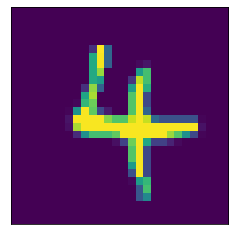

In [0]:
# X_train[indices[3]] is the image of a '4'. The following are the probability scores for each class.
plt.imshow(X_train[indices[3]].reshape(28, 28))
plt.xticks([])
plt.yticks([])

print("Probability scores for each class.")
prob_scores = forest_clf.predict_proba([X_train[indices[3]]])
print(prob_scores)

print("The image belongs to class: {}".format(forest_clf.classes_[np.argmax(prob_scores)]))

We can now evaluate the models (SGDClassifier).

In [0]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

In [0]:
sgd_clf  = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
print("The classifier has been trained")
sgd_scores = cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')
print("Scores for the SGD Classifier: \n", sgd_scores)

The classifier has been trained
Scores for the SGD Classifier: 
 [0.87365 0.85835 0.8689 ]


In [20]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
forest_scaled_clf = RandomForestClassifier(random_state=42)
forest_scaled_clf.fit(X_train_scaled, y_train)
forest_scaled_scores = cross_val_score(sgd_scaled_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')
print("Scores for the SGD Classifier (after scaling): \n", forest_scaled_scores)

Scores for the SGD Classifier (after scaling): 
 [0.8983 0.891  0.9018]


## Error Analysis

In [23]:
from sklearn.metrics import confusion_matrix

forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(X_train_scaled, y_train)
print("Model fit")
y_train_pred = forest_clf.predict(X_train_scaled)
print("Predictions done")
#y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_matrix = confusion_matrix(y_train, y_train_pred)
print(conf_matrix)

Model fit
Predictions done
[[5923    0    0    0    0    0    0    0    0    0]
 [   0 6742    0    0    0    0    0    0    0    0]
 [   0    0 5958    0    0    0    0    0    0    0]
 [   0    0    0 6131    0    0    0    0    0    0]
 [   0    0    0    0 5842    0    0    0    0    0]
 [   0    0    0    0    0 5421    0    0    0    0]
 [   0    0    0    0    0    0 5918    0    0    0]
 [   0    0    0    0    0    0    0 6265    0    0]
 [   0    0    0    0    0    0    0    0 5851    0]
 [   0    0    0    0    0    0    0    0    0 5949]]


The above confusion matrix is for a RandomForestClassifier. In order to understand the matrix better, we should use a SGDClassifier as we will then get some insight into the possible errors too.

In [24]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train_scaled, y_train)
print("SGDClassifier Model fit")
y_train_pred = sgd_clf.predict(X_train_scaled)
print("Predictions done")
#y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_matrix = confusion_matrix(y_train, y_train_pred)
print("Confusion matrix: ")
print(conf_matrix)

SGDClassifier Model fit
Predictions done
Confusion matrix: 
[[5584    0   11    6    6   24   27    3  262    0]
 [   0 6419   39   14    3   41    4    4  214    4]
 [  17   21 5287   67   59   19   48   34  402    4]
 [  20   13   95 5238    0  150   21   36  505   53]
 [   9   12   29    8 5245    6   26   13  384  110]
 [  21   15   21  127   45 4469   66   11  594   52]
 [  25   15   37    2   31   73 5566    6  163    0]
 [  18    9   43   13   37   12    4 5724  250  155]
 [  12   52   33   83    2  101   24    4 5509   31]
 [  19   18   25   51  102   25    1  147  517 5044]]


Pictorial representation of the confusion matrix

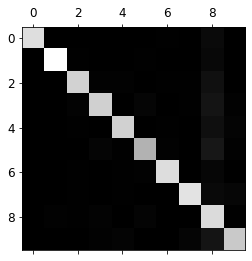

In [25]:
plt.matshow(conf_matrix, cmap = plt.cm.gray)
plt.show()

The brightness of each cell in the above plot corresponds to the value in the previously printed confusion matrix. The diagonal cells represent true positives, that is, where the predicted class matches with the actual class. Since we are interested in the errors, I am going to completely darken the diagonal. Also, it is better to compare the number of errors relative to the total number of examples of that class.

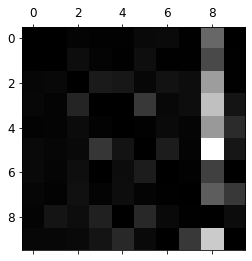

In [26]:
row_sums = conf_matrix.sum(axis=1, keepdims=True)
norm_conf_matrix = conf_matrix/row_sums

np.fill_diagonal(norm_conf_matrix, 0)
plt.matshow(norm_conf_matrix, cmap = plt.cm.gray)
plt.show()

The column for "8" is quite bright. However, the row for "8" is much better (in terms of the errors). The column represents the predicted class. So, in many cases, where the classifier predicts class "8", the number actually belongs to a different class. However, most of the examples of class "8", are being classified correctly. This is why the row corresponding to class "8" is dark (few errors).

Another point to note is that the model gets easily confused between class "3" and class "5".

### Multi-label Classification

I will now try to predict two labels for a given training example. One will tell us whether the number is even or not, and the other will tell us if the number is "small". A "small" number is either 1, 2 or 3.

In [32]:
from sklearn.neighbors import KNeighborsClassifier
y_train_small = (y_train <= 3)
y_train_even = (y_train%2 == 0)

y_train_multilabel = np.c_[y_train_even, y_train_small]

knn_clf = KNeighborsClassifier()

knn_clf.fit(X_train_scaled, y_train_multilabel)

print(knn_clf.predict([X_train_scaled[indices[1]]]))# The number is a 7. Expected output = [False, False]
print(knn_clf.predict([X_train_scaled[indices[3]]]))# The number is a 4. Expected output = [True, False]

[[False False]]
[[ True False]]
